# Packages

In [1]:
# Load Packages 
import pandas as pd
import numpy as np
import math
import os
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

from itertools import combinations
from itertools import chain

from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import random_projection
from sklearn.tree import DecisionTreeRegressor

from dimod import BinaryQuadraticModel
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.preprocessing import roof_duality
# from dwave.system import LeapHybridSampler
# from dwave.system import DWaveSampler
# from dwave.system import EmbeddingComposite
# from dimod import ExactSolver
# from dwave.samplers import TabuSampler
# from dwave.samplers import TreeDecompositionSolver

# Set Path

In [2]:
# Set Path
path  =  os.path.dirname(os.getcwd()) # os.path.dirname(os.getcwd()) #r'/Users/slehmann/Library/CloudStorage/Dropbox/QUBO'

# Simulate Data

In [3]:
# Simulate Data
def sim(n_obs, n_preds, b, p, r):
    
    """
    Simulate Data for Regression Problem
    with pre-determined Covariance Matrix between Predictors
    and pre-determined Coefficients
    """
    
    # Set Seed
    np.random.seed(r)
    
    # Set Covarirance Matrix between Predictors
    cov_mat = np.full((n_preds, n_preds), p)
    np.fill_diagonal(cov_mat, 1.0)

    # Simulate Predictor Time Series
    X = np.random.multivariate_normal([0.0]*n_preds, cov_mat, n_obs)
    #X = pd.DataFrame(X, columns = "X"+pd.Series(range(1, n_preds+1)).astype(str))
    pred_names = "X"+pd.Series(range(1, n_preds+1)).astype(str) #list(X.columns)

    # Set Noise
    noise  =  1.0
    eps    =  np.random.normal(0.0, noise, n_obs)

    # Set Coefficients
    b_scl = b * noise / np.sqrt(n_obs)   

    # Set Target Variable
    y = X @ b_scl + eps
    #y = pd.DataFrame(y, columns = ["Target_Variable"])
    
    # Return
    return(y, X, pred_names)

# Pre-Process Data

In [4]:
# Function to create Lags
def create_lags(y, X, mlags):
    
    """
    ...
    """
    
    # Add all lags from zero to maxlag
    #X = lagmat(y, maxlag = mlags, use_pandas = True).join(X)
    X = np.concatenate((lagmat(y, maxlag = mlags, use_pandas = True), X), axis = 1)
    
    # Return
    return X

In [5]:
# Function to Pre-Process Data
def prepro(y, X, t):
    
    """
    ...
    """
    
    # Train Data
    y_train  =  y[:t]
    X_train  =  X[:t]

    # Predict Data
    y_pred  =  y[t]
    X_pred  =  X[[t]]
    
    # Standardize Data
    scaler  =  StandardScaler()   
    X_train =  scaler.fit_transform(X_train)
    X_pred  =  scaler.transform(X_pred)
    
    # Add Constant
    X_train =  sm.add_constant(X_train)
    X_pred  =  sm.add_constant(X_pred, has_constant = 'add')
    
    ## Train Data
    #y_train  =  y.iloc[:t, :].copy()
    #X_train  =  X.iloc[:t, :].copy()
    #
    ## Predict Data
    #y_pred  =  y.iloc[[t]].copy()
    #X_pred  =  X.iloc[[t]].copy()
    #
    ## Standardize Data
    #scaler  =  StandardScaler()   
    #X_train[X_train.columns] =  scaler.fit_transform(X_train[X_train.columns])
    #X_pred[X_pred.columns]   =  scaler.transform(X_pred[X_pred.columns])
    #
    ## Add Constant
    #X_train =  sm.add_constant(X_train)
    #X_pred  =  sm.add_constant(X_pred, has_constant = 'add')
    
    return y_train, X_train, y_pred, X_pred

# (Complete) Subset Forecasts

In [6]:
# Function to return array of all subsets of length k
def complete_sub(arr, k):
    
    """
    Elements are treated as unique based on their position, not on their value.
    So if the input elements are unique, there will be no repeated values in each combination.
    """
    
    # Get all subsets of size k
    subset  =  list(combinations(arr, k)) 
    
    # Return 
    return subset 

In [7]:
# Function to calculate number of models
def n_models(K, k):
    
    """
    ...
    """
    
    return math.factorial(K) / (math.factorial(k) * math.factorial(K-k))

In [8]:
# Function to randomly select n_max items from array
def random_select(arr, n_max, random_state):
    
    """
    """
    
    # Set random state
    random.seed(random_state)
    
    # Set upper Boundary
    upper_bound  =  len(arr) if len(arr) < n_max else n_max
    
    # Randomly select items without repetition
    rand_arr  =  random.sample(arr, k = upper_bound)
    
    # Return 
    return rand_arr

In [9]:
# Function to produce Subset Regression Forecasts
def ssf(y_train, X_train, X_pred, feature, mlags):
    
    # Subset Feature Space (incl. constant)
    X_train_subset = X_train[:, list(range(0, mlags+1)) + list(feature)]
    X_pred_subset  = X_pred[:, list(range(0, mlags+1)) + list(feature)]
    #X_train_subset = X_train.iloc[:, list(range(0, mlags+1)) + list(feature)]
    #X_pred_subset  = X_pred.iloc[:, list(range(0, mlags+1)) + list(feature)]
    
    # Fit Model
    model = sm.OLS(y_train, X_train_subset)
    regr = model.fit()
    
    # Predict
    pred = regr.predict(X_pred_subset)
    
    return(pred[0], regr.params[1:])

# Compressed Regressions

In [10]:
# Compressed Regression (Gaussian random projection)
def cr_reg(y_train, X_train, X_pred, n_comp, mlags, ran_st):
    
    # Set up Random-Projection-Matrix
    transformer = random_projection.GaussianRandomProjection(n_components = n_comp, random_state = ran_st)
    
    # Transform
    tmp_train  =  transformer.fit_transform(X_train[:, (mlags+1):])
    tmp_pred   =  transformer.fit_transform(X_pred[:,  (mlags+1):])

    ## Convert to DataFrame
    #tmp_train  =  transformer.fit_transform(X_train.iloc[:, (mlags+1):])
    #tmp_pred   =  transformer.fit_transform(X_pred.iloc[:,  (mlags+1):])
    #tmp_train  =  pd.DataFrame(tmp_train, index = X_train.index)
    #tmp_pred   =  pd.DataFrame(tmp_pred,  index = X_pred.index)

    # Add Constant + Lags
    comp_matrix_train =  np.concatenate([X_train[:, :(mlags+1)], tmp_train], axis = 1)
    comp_matrix_pred  =  np.concatenate([X_pred[:,  :(mlags+1)], tmp_pred],  axis = 1)
    #comp_matrix_train =  pd.concat([X_train.iloc[:, :(mlags+1)], tmp_train], axis = 1)
    #comp_matrix_pred  =  pd.concat([X_pred.iloc[:,  :(mlags+1)], tmp_pred],  axis = 1)

    # Fit Model
    model  =  sm.OLS(y_train, comp_matrix_train)
    regr   =  model.fit()
    
    # Predict
    pred = regr.predict(comp_matrix_pred)
    
    return pred[0]

# Decision Trees

In [11]:
# Decision Tree Regression
def dt_reg(y_train, X_train, X_pred, ran_st):
    
    # Set up Regressor Object 
    model = DecisionTreeRegressor(criterion = "squared_error",
                                  max_depth = 20,
                                  splitter  = "random",
                                  random_state = ran_st)
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    pred = model.predict(X_pred)

    # Return Prediction
    return pred[0]

# AR-Model

In [12]:
# Autoregressive Model
def ar_mod(y_train, lags):

    # Fit AR-Model
    model = AutoReg(y_train, lags=lags).fit()
    
    # Prediction
    pred = model.forecast(steps=1)

    # Return Prediction
    return pred[0]

# Best Selection of Forecasts

In [111]:
# Best Selection of Forecasts
def bssf(Y_train, X_train, X_pred, alpha, n_sub, n_times):
    
    # Adapt X-Matrix
    X_train  =  X_train / n_sub
    X_pred   =  X_pred  / n_sub
    
    # Generate Q-Matrix
    ivec      =  np.mat(np.ones(X_train.shape[1])).transpose()
    aux_mat   =  np.array(Y_train.transpose() @ X_train + alpha * n_sub)
    diag_mat  =  np.diag(aux_mat) # np.diag(aux_mat[0])
    Q         =  - 2 * diag_mat + X_train.transpose() @ X_train + alpha * ivec @ ivec.transpose()

    # Initialize BQM
    bqm  =  BinaryQuadraticModel('BINARY')
    bqm  =  bqm.from_qubo(Q)
    
    # Normalize
    bqm.normalize()
    
    # Preprocess (?)
    #roof_duality(bqm)    
    
    # Select Solver
    solver_qpu  =  SimulatedAnnealingSampler() #LeapHybridSampler() SimulatedAnnealingSampler() EmbeddingComposite(DWaveSampler())
    #solver_pp   =  SteepestDescentSolver()     #SteepestDescentSolver()

    # Submit for Solution
    sampleset  =  solver_qpu.sample(bqm, 
                                    num_reads = n_times,
                                    #time_limit = 90,
                                    label = "Best Subset Selection of Forecasts") # f'Best Subset Selection of Forecasts{t}'
    
    ## Postprocess Problem
    #sampleset_pp = solver_pp.sample(bqm,
    #                                initial_states = sampleset.lowest())

    # Get Solution
    #solution   =  list(sampleset.first[0].values())
    solution    =  np.array(list(sampleset.first[0].values()))
    
    # Test
    if np.sum(solution) != n_sub:
        print("Error: Number of selected features does not match!")
    
    # Prediction 
    #pred       = solution @ X_pred
    pred       = solution @ X_pred.transpose()
    
    # Return 
    return(pred[0], solution)

# Application

In [ ]:
# Load Goyal Welch Data
data  =  pd.read_csv(path + r'/Data/PredictorData2022.xlsx - Quarterly.csv', thousands=',')

# Equity Premium
data['equity_premium'] = data['CRSP_SPvw'] - data['Rfree']

# Dividend Price Ratio 
data['dp'] = np.log(data['D12']) - np.log(data['Index'])

# Dividend Yield 
data['dy'] = np.log(data['D12'])- np.log(data['Index'].shift(1))

# Earnings Price Ratio 
data['ep'] = np.log(data['E12']) - np.log(data['Index'])

# Dividend Payout Ratio 
data['dpayr'] = np.log(data['D12']) - np.log(data['E12'])

# Book to Market Ratio
data['bmr'] = data['b/m']

# # Net Equity Expansion
data['ntis'] = data['ntis']

# Treasury Bill Rate
data['tbl'] = data['tbl']

# Long Term Rate
data['ltr'] = data['ltr']

# Term Spread 
data['tsp'] = data['lty'] - data['tbl']

# Default Return Spread 
data['dfr'] = data['corpr'] - data['ltr']

# Inflation
data['infl'] = data['infl']

# Investment of Capital Ratio
data['ik']  = data['ik']

# Default Yield Spread
data['dfy'] = data['BAA'] - data['AAA']

# Realized Volatility
data['rvol'] = data['svar']

# reorganize the dataframe
data = data[['yyyyq', "equity_premium", "dp", "dy", "ep", "dpayr", "bmr", "ntis", "tbl", "ltr", "tsp", "dfr", "infl", "ik"]]

# Convert Date
data['yyyyq'] = data['yyyyq'].astype(str)
data['yyyyq'] = data.apply(lambda x: x['yyyyq'][:4]+'-Q'+x['yyyyq'][4:], axis=1)
data['yyyyq'] = pd.to_datetime(data['yyyyq'])

# Resetting the index
data.set_index('yyyyq', inplace=True)
data.index = data.index.to_period('Q')

# Lag all Predictors
data.iloc[:,1:]  =  data.iloc[:,1:].shift(1)

# Drop Na
data = data.loc["1946Q1":, ]

In [ ]:
###### Set Seed ######
#random.seed(123)

###### Data ######
# Set Target Variable
y  =  data.loc[:, ["equity_premium"]]
X  =  data.drop("equity_premium", axis = 1)

# Get Predictor Names
pred_names = list(X.columns)

# Number of AR-Terms to include
mlags =  2

# Create Lags
X  =  create_lags(y, X, mlags)

# Drop Missing Values
y  =  y.loc["1947Q2":, ] #y[mlags:]
X  =  X.loc["1947Q2":, ] #X[mlags:]

# Check NA
any(X.isna().any())

###### Parameter Subset Forecasts
# Subset Lengths
k_range = [1, 2, 3] # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Upper Bound for Subset-Sizes
n_max = 10000  # 20000

# Number of Subset-Forecasts
n_sub  =  int(sum([min(n_models((X.shape[1]-mlags), k), n_max) for k in k_range]))

###### Parameter Compressed Regressions ######
# Number of Components for Compressed Regression
cr_range  =  [1, 2, 3] # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Number of runs for each random projection
rep_range  =  range(0, 100) # 10000

# Number of Compressed-Regression-Forecasts
n_cr  =  len(cr_range) * len(rep_range)

# ###### Parameter Decision Tree ######
# dt_range  =  range(0, 5) # 300000
# 
# # Number of Decision Trees
# n_dt  =  len(dt_range)

###### Parameter BSSF ######
alpha       =  0.5
n_times     =  50
bssf_range  =  [1, 2, 3] # range(1, 5)
n_bssf      =  len(bssf_range)

### General Parameter ######
# Initial Training-Period
init       =  4 * 50 #4 * 10

# Total Length
total =  len(y) 

# Set up Matrices for Results
cand_forecasts  =  np.full((total, (n_sub + n_cr)), np.nan)     #np.full((total, (n_sub + n_cr + n_dt)), np.nan)
cf_weights      =  np.full((total, (n_sub + n_cr)), np.nan)
benchmark       =  np.full(total, np.nan)
bssf_forecast   =  np.full(total, np.nan)
bssf_opt        =  np.full(total, np.nan)
sse_bssf        =  np.zeros(n_bssf)

###### Start ######
# Loop over Time
for t in tqdm(range(init, total)):
        
    # Pre-Process Data
    y_train, X_train, y_pred, X_pred = prepro(y, X, t)
    
    ### Benchmark: AR(X) Model
    pred          =  ar_mod(y_train, lags = mlags)
    benchmark[t]  =  pred.iloc[0]
    
    ### Subset Forecasts
    # Set up List to store Subset-Forecasts
    preds_ssf =  np.full(n_sub, np.nan)
    idx_sub   =  0
    
    # Loop over Subset Size 
    for k in k_range:
    
        # Get all possible Subset of length k
        col_idx   =  list(range(mlags+1, X_train.shape[1]))
        subs_idx  =  complete_sub(col_idx, k)

        # Randomly select n_upper Subsets
        feature_set  =  subs_idx #random_select(subs_idx, n_max, random_state = 123)

        # Loop over Subsets
        for feature in feature_set:

            # Compute Subset-Regression-Forecast
            pred  =  ssf(y_train, X_train, X_pred, feature, mlags)
            preds_ssf[idx_sub] = pred
            idx_sub += 1
            
    ### Compressed Regressions
    # Set up List to store Compressed-Regression-Forecasts
    preds_cr = np.full(n_cr, np.nan)
    idx_cr   = 0
    
    # Loop over number of Components
    for n_comp in cr_range:

        # Loop over n repetitions
        for r in rep_range:
        
            # Compute Compressed-Regression-Forecasts
            pred  =  cr_reg(y_train, X_train, X_pred, n_comp, mlags, r)
            preds_cr[idx_cr] = pred
            idx_cr += 1
            
    # ### Decision Tree Regressions
    # # Set up Matrix to store Decision-Tree-Forecasts
    # preds_dt   = np.full(n_dt, np.nan)
    # 
    # # Loop over number of Components
    # for idx_dt, r in enumerate(dt_range):
    #     
    #     # Compute Decision-Tree-Forecasts
    #     pred  =  dt_reg(y_train, X_train, X_pred, r)
    #     preds_dt[idx_dt] = pred[0]

    # Append Results
    cand_forecasts[t][:n_sub]             =  preds_ssf 
    cand_forecasts[t][n_sub:(n_sub+n_cr)] =  preds_cr
    #cand_forecasts[t][(n_sub+n_cr):]      =  preds_dt

    ### Best Selection of Forecast
    if t > init:
    
        # Set up Matrix to store Forecasts
        bssf_forecasts  =  np.full(n_bssf, np.nan)
        bssf_weights    =  np.zeros([n_bssf, n_sub + n_cr]) 
           
        # Get "best" Subset-Size until now (lowest Sum of Squared Errors)
        s_opt  =  np.argmin(sse_bssf)
    
        # Loop over Subset Sizes
        for idx_bssf, s in enumerate(bssf_range):
    
            # Compute Best-Subset-Selection-of-Forecasts
            pred  =  bssf(y_train[init:], cand_forecasts[init:t], cand_forecasts[t], alpha, s, n_times)
            bssf_forecasts[idx_bssf]  =  pred[0]
            bssf_weights[idx_bssf]    =  pred[1]
    
            # Compute Sum of Squared Errors
            sse_bssf[idx_bssf] =  sse_bssf[idx_bssf] + (y_pred.iloc[0,0] - pred[0]) ** 2
    
        # Select Forecast 
        bssf_forecast[t] =  bssf_forecasts[s_opt]
        cf_weights[t]    =  bssf_weights[s_opt]
        bssf_opt[t]      =  bssf_range[s_opt]
        
# Candidate-Model-Names
ssf_names = [f"SSF{k}_" + "_".join(map(str, sub)) for k in k_range for sub in combinations(range(len(pred_names)), k)]
cr_names  = [f"CR{n_comp}_{r}" for n_comp in cr_range for r in rep_range]
#dt_names = [f"DT_{idx_dt}" for idx_dt in dt_range]
        
# Convert Results to DataFrame
cand_forecasts  =  pd.DataFrame(cand_forecasts, index = y.index, columns = [*ssf_names, *cr_names]) #, *dt_names])
benchmark       =  pd.DataFrame(benchmark,      index = y.index, columns = ["AR"])
bssf_forecast   =  pd.DataFrame(bssf_forecast,  index = y.index, columns = ["BSSF"])
cf_weights      =  pd.DataFrame(cf_weights,     index = y.index, columns = [*ssf_names, *cr_names]) #, *dt_names])
bssf_opt        =  pd.DataFrame(bssf_opt,     index = y.index, columns = ["Subset_Size"])

# Cut off initial Training-Period
sub_y              =  y.iloc[init:].copy()
sub_cand_forecasts =  cand_forecasts.iloc[init:].copy()
sub_benchmark      =  benchmark.iloc[init:].copy()
sub_bssf_forecast  =  bssf_forecast.iloc[init:].copy()
sub_cf_weights     =  cf_weights.iloc[init:].copy()
sub_bssf_opt       =  bssf_opt.iloc[init:].copy()

# OOS-Period
oos_start  =  "1999Q4"
oos_end    =  "2022Q4" 
oos_y             =  sub_y.loc[oos_start:oos_end].copy()
oos_cand_forecast =  sub_cand_forecasts.loc[oos_start:oos_end].copy()
oos_benchmark     =  sub_benchmark.loc[oos_start:oos_end].copy()
oos_bssf_forecast =  sub_bssf_forecast.loc[oos_start:oos_end].copy()
oos_cf_weights    =  sub_cf_weights.loc[oos_start:oos_end].copy()
oos_bssf_opt      =  sub_bssf_opt.loc[oos_start:oos_end].copy()

# Evaluation
np.sum((oos_y.iloc[:,0] - oos_bssf_forecast.iloc[:,0]) ** 2) / np.sum((oos_y.iloc[:,0] - oos_benchmark.iloc[:,0]) ** 2)

In [ ]:
### Forecasts plottten

In [ ]:
# Replace Zero with NaN
oos_cf_weights.replace({0:np.nan}, inplace=True)

# Adapt Column-Values
vec = list(range(1, oos_cf_weights.shape[1]+1))
tmp = oos_cf_weights * vec

# Dates
tmp = tmp.reset_index(names="date")

# Plot 
# tmp.plot(x='date', y = tmp.columns[1:],
#          figsize=(10, 5), legend=False,
#          marker="o", ms = 1, 
#          title="Selected Candidate Models", ylabel="Selected Candidate Models")
#          #yticks = (np.arange(98), list(tmp.columns[1:])))

tmp_long = pd.melt(tmp, id_vars = "date")
tmp_long['variable'] = tmp_long['variable'].str.startswith("SSF").replace({True: "SSF", False: "CR"})
tmp_long.set_index("date", inplace = True)
tmp_long.groupby("variable")["value"].plot(legend=True, figsize = (10, 5),
                                           marker="o", ms = 2, lw = 0,
                                           ylim = [-1, cand_forecasts.shape[1]+1],
                                           title="Selected Candidate Models", ylabel="Selected Candidate Models")
plt.show()

# Subset Size
oos_bssf_opt.plot(figsize=(10, 5), legend=False, 
                  color = "black", marker="o", ms = 1, lw = 0,
                  title = "Subset Size", xlabel="date", ylabel="Selected Subset Size",
                  ylim  =  [min(bssf_range)-0.5, max(bssf_range)+0.5],
                  yticks = np.arange(min(bssf_range), max(bssf_range)+1, step=1.0))
plt.show()

# CSSED
cssed = np.cumsum(((oos_y.iloc[:,0] - oos_benchmark.iloc[:,0]) ** 2) - ((oos_y.iloc[:,0] - oos_bssf_forecast.iloc[:,0]) ** 2))
cssed.plot(figsize=(10, 5),
            xlabel = "date", ylabel = "CSSED", title = "Cumulated Sum of Squared Error Differences")
plt.show()

# Simulation

In [112]:
###### MC-Parameter ######
# Number of MC-Runs
n_mc  =  3

# Set Parameter
n_obs       =  100
n_preds     =  8
init        =  50
mlags       =  0
corr_range  =  [0, 0.5, 0.95]
b_range     =  np.array([[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

###### Parameter Subset Forecasts ######
# Subset Lengths
k_range = [1, 2, 3, 4, 5, 6, 7, 8] 

# Upper Bound for Subset-Sizes
n_max = 10000  

# Number of Subset-Forecasts
n_sub  =  int(sum([min(n_models(n_preds, k), n_max) for k in k_range]))

###### Parameter Compressed Regressions ######
# Number of Components for Compressed Regression
cr_range  =  [1, 2] 

# Number of runs for each random projection
rep_range  =  range(0, 50) 

# Number of Compressed-Regression-Forecasts
n_cr  =  len(cr_range) * len(rep_range)

# ###### Parameter Decision Tree ######
# dt_range  =  range(0, 5) 
# 
# # Number of Decision Trees
# n_dt  =  len(dt_range)

###### Parameter BSSF ######
alpha       =  10.0
n_times     =  1
bssf_range  =  [1, 2, 3] 
n_bssf      =  len(bssf_range)

######## Objects ########
# Set up Matrices for Results
cand_forecasts   = np.full((len(range(init, n_obs)), (n_sub + n_cr)), np.nan)     
benchmark        = np.full( len(corr_range) * len(b_range) * n_mc, np.nan)
cf_weights       = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf, (n_sub + n_cr)), np.nan)
bssf_forecast    = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf), np.nan)
csr_forecast     = np.full((len(corr_range) * len(b_range) * n_mc, len(k_range)), np.nan)
se_benchmark     = np.full( len(corr_range) * len(b_range) * n_mc, np.nan)
se_bssf_forecast = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf), np.nan)
se_csr_forecast  = np.full((len(corr_range) * len(b_range) * n_mc, len(k_range)), np.nan)

###### Start ######
# Loop over Monte-Carlo Runs
i = 0
for r in tqdm(range(n_mc)):
    
    # Loop over Covariance-Sets
    for p in corr_range:
        
        # Loop over Coefficient-Sets
        for b in b_range:
    
            ### Simulate Data ###
            y, X, pred_names = sim(n_obs, n_preds, b, p, r)
            
            ### Benchmark: PHM ###
            benchmark[i]    = y[:-1].mean()
            se_benchmark[i] = (y[-1] - benchmark[i]) ** 2

            # Loop over t / Create Candidate Models
            for t in range(init, n_obs):
            
                ### Pre-Process Data ###
                y_train, X_train, y_pred, X_pred = prepro(y, X, t)

                ### Subset Forecasts ###
                feature_set  =  list(chain(*list(map(lambda k: complete_sub(list(range(1, X_train.shape[1])), k), k_range))))
                preds_ssf, coeffs  =  zip(*list(map(lambda feature: ssf(y_train, X_train, X_pred, feature, 0), feature_set)))

                ### Compressed Regressions ###
                preds_cr = np.array(list(chain(*[list(map(lambda rep: cr_reg(y_train, X_train, X_pred, n_comp, 0, rep), rep_range)) for n_comp in cr_range])))

                # ### Decision Tree Regressions ###
                # preds_dt = np.array(list(map(lambda r: dt_reg(y_train, X_train, X_pred, r), dt_range)))

                # Append Results
                cand_forecasts[t-init][:n_sub]             =  preds_ssf 
                cand_forecasts[t-init][n_sub:(n_sub+n_cr)] =  preds_cr
                #cand_forecasts[t-init][(n_sub+n_cr):]     =  preds_dt
                
            ### Benchmark: Complete Subset Regression ###
            tmp_ = np.cumsum([0] + [len(list(combinations(range(n_preds), k))) for k in k_range])
            csr_forecast[i]     =  [np.mean(preds_ssf[tmp_[i]:tmp_[i+1]]) for i in range(len(tmp_)-1)]
            se_csr_forecast[i]  =  (y_pred - csr_forecast[i]) ** 2

            ### Best Selection of Forecast ###
            bssf_forecast[i], cf_weights[i] = zip(*list(map(lambda s: bssf(y_train[init:], cand_forecasts[:-1], cand_forecasts[[-1]], alpha, s, n_times), bssf_range)))
            se_bssf_forecast[i] = (y_pred - bssf_forecast[i]) ** 2
             
            # Update index   
            i += 1
            
# # Candidate-Model-Names
ssf_names = [f"SSF{k}_" + "_".join(map(str, sub)) for k in k_range for sub in combinations(range(n_preds), k)]
cr_names  = [f"CR{n_comp}_{r}" for n_comp in cr_range for r in rep_range]

### Evaluation ###
for b in range(len(b_range)):
    for p in range(len(corr_range)):
        
        se_bssf = se_bssf_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_csr  = se_csr_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_phm  = se_benchmark[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        
        print(f"BSSF: Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is: " + str(np.round(100 * (1 - sum(se_bssf) / sum(se_phm)), 2)) + "%")
        print(f"CSR:  Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is: " + str(np.round(100 * (1 - sum(se_csr) / sum(se_phm)), 2)) + "%")

  0%|          | 0/3 [00:00<?, ?it/s]

Error: Number of selected features does not match!
Error: Number of selected features does not match!


100%|██████████| 3/3 [01:03<00:00, 21.10s/it]

BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ 8.49 15.52  5.31]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [-0.12  0.23  1.05  2.33  4.04  6.11  8.49 11.07]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ 0.1  -3.6  23.78]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ 2.56  3.61  4.62  5.83  7.28  8.93 10.72 12.56]%
BSSF: Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ 3.6  -4.83  4.71]%
CSR:  Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ 7.28  8.51  9.57 10.69 11.93 13.29 14.76 16.3 ]%
BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [18.55  5.24 12.41]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [-0.23  0.14  1.07  2.49  4.28  6.33  8.46 10.5 ]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [-39.42   7.71  -0.29]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 

In [23]:
pd.DataFrame(coeffs, columns = pred_names)

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.810318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.886190,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.792231,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.805410,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.849732,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
250,-0.120954,1.389508,-0.583211,NaN,0.735766,-0.494176,-0.620704,0.545979
251,-0.150840,1.244457,NaN,-0.078133,0.675002,-0.522154,-0.719460,0.408523
252,0.038581,NaN,-0.229315,0.062683,0.979324,-0.219543,-0.617798,0.824681
253,NaN,1.375433,-0.590800,-0.017787,0.724401,-0.519514,-0.624705,0.506310


In [ ]:
### MC=40
BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [6.5]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [2.03 3.86 5.47 6.85 7.96 8.79 9.31 9.49]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [8.41]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [6.02 7.28 7.6  7.44 6.91 6.06 4.9  3.44]%
BSSF: Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [23.63]%
CSR:  Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [21.45 21.72 21.55 21.09 20.38 19.4  18.16 16.66]%
BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [-0.59]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [ 0.07 -0.16 -0.65 -1.4  -2.37 -3.55 -4.91 -6.45]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [23.4]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [19.82 23.68 24.98 25.41 25.4  25.06 24.44 23.54]%
BSSF: Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [52.02]%
CSR:  Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [56.09 57.59 58.47 59.01 59.27 59.28 59.03 58.55]%

### MC=40
BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [-25.66]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [ -0.03  -0.74  -2.1   -4.12  -6.79 -10.12 -14.11 -18.81]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [9.13]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [15.26 19.61 21.94 23.32 23.97 23.93 23.2  21.7 ]%
BSSF: Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [23.05]%
CSR:  Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 0. 0. 0. 0.] is: [19.26 19.46 19.34 18.92 18.19 17.13 15.73 13.92]%
BSSF: Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [-0.84]%
CSR:  Avg. OOS-R2 for Corr. 0 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [2.22 4.09 5.63 6.83 7.68 8.15 8.2  7.76]%
BSSF: Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [9.71]%
CSR:  Avg. OOS-R2 for Corr. 0.5 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [20.82 23.4  23.69 23.28 22.47 21.35 19.9  18.08]%
BSSF: Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [31.92]%
CSR:  Avg. OOS-R2 for Corr. 0.95 and Betas [1. 1. 1. 1. 1. 1. 1. 1.] is: [34.96 35.1  35.02 34.67 34.02 33.03 31.66 29.88]%

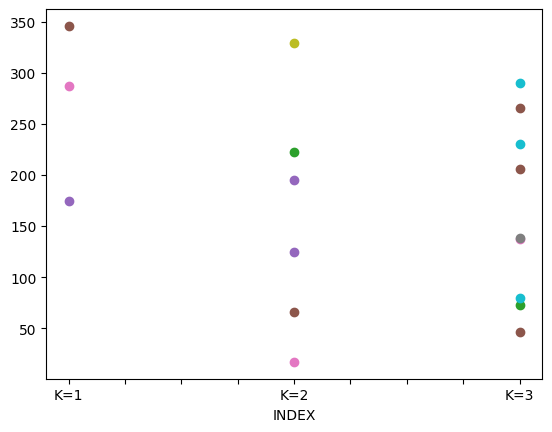

In [113]:
# Subset Weights
tmp_ = sum(cf_weights[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))])

# Create DataFrame
chosen_cm = pd.DataFrame(tmp_, index = [f"K={k}" for k in bssf_range], columns = [*ssf_names, *cr_names])

# Replace Zero with NaN
chosen_cm.replace({0:np.nan}, inplace=True)

# Adapt Column-Values
vec = list(range(1, chosen_cm.shape[1]+1))
tmp = chosen_cm * vec

# Index
tmp = tmp.reset_index(names="INDEX")

# Plot 
tmp.plot(kind = 'line', x = 'INDEX', y = tmp.columns[1:], legend = None, marker = "o")
plt.show()

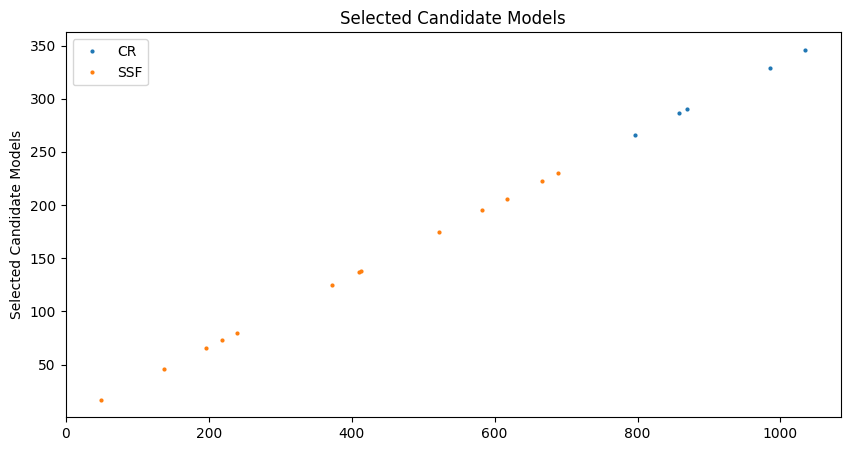

In [114]:
# Replace Zero with NaN
chosen_cm.replace({0:np.nan}, inplace=True)

# Adapt Column-Values
vec = list(range(1, chosen_cm.shape[1]+1))
tmp = chosen_cm * vec

# Index
tmp = tmp.reset_index(names="INDEX")

tmp_long = pd.melt(tmp, id_vars = "INDEX")
tmp_long['variable'] = tmp_long['variable'].str.startswith("SSF").replace({True: "SSF", False: "CR"})
#tmp_long.set_index("INDEX", inplace = True)
tmp_long.groupby("variable")["value"].plot(legend=True, figsize = (10, 5),
                                           marker="o", ms = 2, lw = 0,
                                           #ylim = [-1, cand_forecasts.shape[1]+1],
                                           title="Selected Candidate Models", ylabel="Selected Candidate Models")
plt.show()

<Axes: title={'center': 'Selected Candidate Models'}, xlabel='INDEX', ylabel='Selected Candidate Models'>

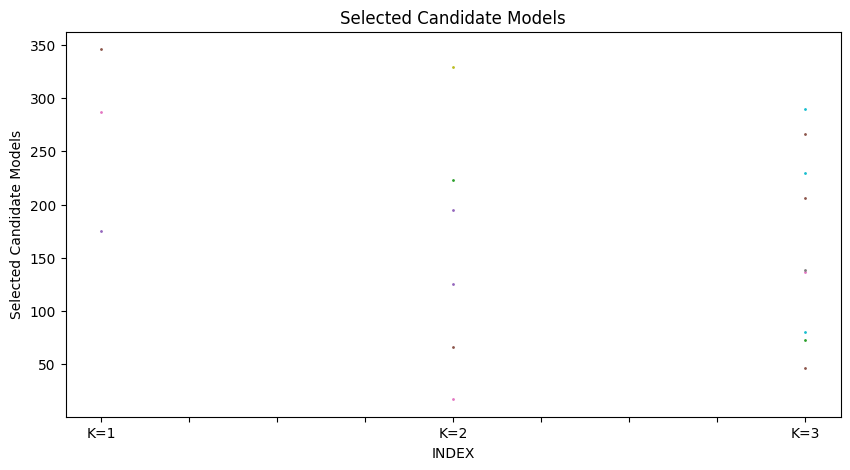

In [115]:
# Plot 
tmp.plot(x='INDEX', y = tmp.columns[1:],
         figsize=(10, 5), legend=False,
         marker="o", ms = 1, 
         title="Selected Candidate Models", ylabel="Selected Candidate Models")
         #yticks = (np.arange(98), list(tmp.columns[1:])))

<Axes: title={'center': 'Chosen Candidate Models'}, xlabel='Size', ylabel='Candidate Models'>

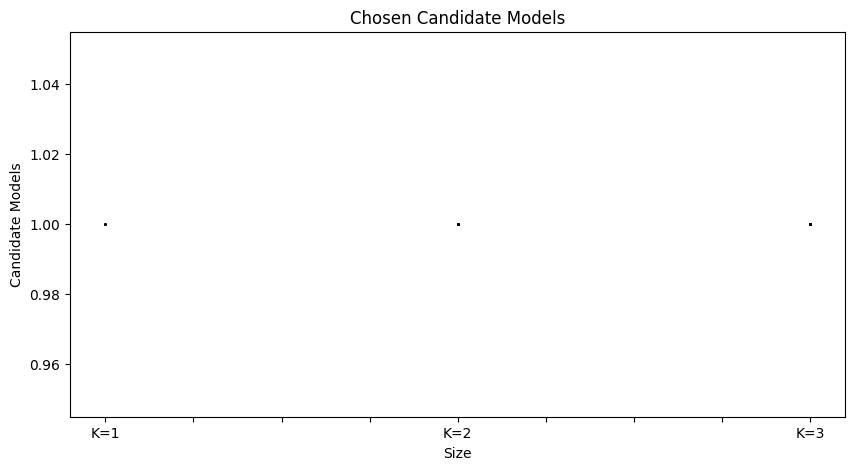

In [117]:
# Subset Size
chosen_cm.plot(figsize=(10, 5), legend=False, 
               color = "black", marker="o", ms = 1, lw = 0,
               title = "Chosen Candidate Models", xlabel="Size", ylabel="Candidate Models")

In [ ]:
# plot
plt.plot(se_bssf_forecast)
plt.plot(se_csr_forecast)
plt.plot(se_benchmark)

In [ ]:
### Plot: Welches K hat was ausgewählt
### Benchmark: Complete Subset Regression

In [ ]:
for b in range(len(b_range)):
    for p in range(len(corr_range)):
        
        se_bssf = se_bssf_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_csr  = se_csr_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_phm  = se_benchmark[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        
        print(f"BSSF: Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is:" + str(np.round(100 * (1 - sum(se_bssf) / sum(se_phm)), 2)) + "%")
        print(f"CSR:  Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is:" + str(np.round(100 * (1 - sum(se_csr) / sum(se_phm)), 2)) + "%")

In [ ]:
b1 = benchmark[np.arange(0, n_mc * len(corr_range) * len(b_range), len(b_range))]
b2 = benchmark[np.arange(1, n_mc * len(corr_range) * len(b_range), len(b_range))]

b1_p1 = b1[np.arange(0, n_mc * len(corr_range), len(corr_range))]
b1_p2 = b1[np.arange(1, n_mc * len(corr_range), len(corr_range))]
b1_p3 = b1[np.arange(2, n_mc * len(corr_range), len(corr_range))]

b2_p1 = b2[np.arange(0, n_mc * len(corr_range), len(corr_range))]
b2_p2 = b2[np.arange(1, n_mc * len(corr_range), len(corr_range))]
b2_p3 = b2[np.arange(2, n_mc * len(corr_range), len(corr_range))]

-------------

------------------

# Old Data

In [ ]:
###### MC-Parameter ######
# Number of MC-Runs
n_mc  =  2

# Set Parameter
n_obs       =  100
n_preds     =  8
init        =  50
mlags       =  0
corr_range  =  [0.5, 0.95]
b_range     =  np.array([[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

###### Parameter Subset Forecasts ######
# Subset Lengths
k_range = [1, 2, 3, 4, 5, 6, 7, 8] 

# Upper Bound for Subset-Sizes
n_max = 10000  

# Number of Subset-Forecasts
n_sub  =  int(sum([min(n_models(n_preds, k), n_max) for k in k_range]))

###### Parameter Compressed Regressions ######
# Number of Components for Compressed Regression
cr_range  =  [1, 2] 

# Number of runs for each random projection
rep_range  =  range(0, 50) 

# Number of Compressed-Regression-Forecasts
n_cr  =  len(cr_range) * len(rep_range)

# ###### Parameter Decision Tree ######
# dt_range  =  range(0, 5) 
# 
# # Number of Decision Trees
# n_dt  =  len(dt_range)

###### Parameter BSSF ######
alpha       =  10.0
n_times     =  1
bssf_range  =  [1, 2, 3] 
n_bssf      =  len(bssf_range)

######## Objects ########
# Set up Matrices for Results
cand_forecasts   = np.full((len(range(init, n_obs)), (n_sub + n_cr)), np.nan)     
benchmark        = np.full( len(corr_range) * len(b_range) * n_mc, np.nan)
cf_weights       = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf, (n_sub + n_cr)), np.nan)
bssf_forecast    = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf), np.nan)
csr_forecast     = np.full((len(corr_range) * len(b_range) * n_mc, len(k_range)), np.nan)
se_benchmark     = np.full( len(corr_range) * len(b_range) * n_mc, np.nan)
se_bssf_forecast = np.full((len(corr_range) * len(b_range) * n_mc, n_bssf), np.nan)
se_csr_forecast  = np.full((len(corr_range) * len(b_range) * n_mc, len(k_range)), np.nan)

###### Start ######
# Loop over Monte-Carlo Runs
i = 0
for r in tqdm(range(n_mc)):
    
    # Loop over Covariance-Sets
    for p in corr_range:
        
        # Loop over Coefficient-Sets
        for b in b_range:
    
            ### Simulate Data ###
            y, X, pred_names = sim(n_obs, n_preds, b, p, r)
            
            ### Benchmark: PHM ###
            benchmark[i]    = y.iloc[:-1].mean().iloc[0]
            se_benchmark[i] = (y.iloc[-1,0] - benchmark[i]) ** 2

            # Loop over t / Create Candidate Models
            for t in range(init, n_obs):
            
                ### Pre-Process Data ###
                y_train, X_train, y_pred, X_pred = prepro(y, X, t)

                ### Subset Forecasts ###
                feature_set  =  list(chain(*list(map(lambda k: complete_sub(list(range(1, X_train.shape[1])), k), k_range))))
                preds_ssf    =  np.array(list(map(lambda feature: ssf(y_train, X_train, X_pred, feature, 0), feature_set)))
            
                ## Set up List to store Subset-Forecasts
                #preds_ssf = np.full(n_sub, np.nan)
                #idx_sub   = 0
                #
                ## Loop over Subset Size 
                #for k in k_range:
                #
                #    # Get all possible Subsets of length k
                #    col_idx  = list(range(1, X_train.shape[1]))
                #    subs_idx = complete_sub(col_idx, k)
                #
                #    # Randomly select n_upper Subsets
                #    feature_set  =  subs_idx #random_select(subs_idx, n_max, random_state = 123)
                #
                #    # Loop over Subsets
                #    for feature in feature_set:
                #    
                #        # Compute Subset-Regression-Forecast
                #        pred  =  ssf(y_train, X_train, X_pred, feature, 0)
                #        preds_ssf[idx_sub] = pred
                #        idx_sub += 1

                ### Compressed Regressions ###
                preds_cr = np.array(list(chain(*[list(map(lambda rep: cr_reg(y_train, X_train, X_pred, n_comp, 0, rep), rep_range)) for n_comp in cr_range])))
                
                # # Set up List to store Compressed-Regression-Forecasts
                # preds_cr   = np.full(n_cr, np.nan)
                # idx_cr     = 0
                # 
                # # Loop over number of Components
                # for n_comp in cr_range:
                # 
                #     # Loop over n repetitions
                #     for rep in rep_range:
                #     
                #         # Compute Compressed-Regression-Forecasts
                #         pred  =  cr_reg(y_train, X_train, X_pred, n_comp, 0, rep)
                #         preds_cr[idx_cr] = pred
                #         idx_cr += 1

                # ### Decision Tree Regressions
                # preds_dt = np.array(list(map(lambda r: dt_reg(y_train, X_train, X_pred, r), dt_range)))
                
                # # Set up Matrix to store Decision-Tree-Forecasts
                # preds_dt   = np.full(n_dt, np.nan)
                # 
                # # Loop over number of Components
                # for idx_dt, r in enumerate(dt_range):
                #     
                #     # Compute Decision-Tree-Forecasts
                #     pred  =  dt_reg(y_train, X_train, X_pred, r)
                #     preds_dt[idx_dt] = pred[0]

                # Append Results
                cand_forecasts[t-init][:n_sub]             =  preds_ssf 
                cand_forecasts[t-init][n_sub:(n_sub+n_cr)] =  preds_cr
                #cand_forecasts[t-init][(n_sub+n_cr):]     =  preds_dt
                
            ### Benchmark: Complete Subset Regression ###
            tmp_ = np.cumsum([0] + [len(list(combinations(range(n_preds), k))) for k in k_range])
            csr_forecast[i]     =  [np.mean(preds_ssf[tmp_[i]:tmp_[i+1]]) for i in range(len(tmp_)-1)]
            se_csr_forecast[i]  =  (y_pred.iloc[0,0] - csr_forecast[i]) ** 2

            ### Best Selection of Forecast ###
            bssf_forecast[i], cf_weights[i] = zip(*list(map(lambda s: bssf(y_train[init:], cand_forecasts[:-1], cand_forecasts[-1], alpha, s, n_times), bssf_range)))
            se_bssf_forecast[i] = (y_pred.values[0] - bssf_forecast[i]) ** 2
            
            # # Set up Matrix to store Forecasts
            # kssf_forecasts  =  np.full(n_bssf, np.nan)
            # kssf_weights    =  np.zeros([n_bssf, n_sub + n_cr]) 

            # # Loop over Subset Sizes
            # for idx_bssf, s in enumerate(bssf_range):
            #     
            #     # Compute Best-Subset-Selection-of-Forecasts
            #     pred = bssf(y_train[init:], cand_forecasts[:-1], cand_forecasts[-1], alpha, s, n_times)
            #     bssf_forecast[i][idx_bssf] = pred[0]
            #     cf_weights[i][idx_bssf]    = pred[1]
            #     se_bssf_forecast[i][idx_bssf] = (y_pred.iloc[0,0] - pred[0]) ** 2
             
            # Update index   
            i += 1
            
# # Candidate-Model-Names
ssf_names = [f"SSF{k}_" + "_".join(map(str, sub)) for k in k_range for sub in combinations(range(n_preds), k)]
cr_names  = [f"CR{n_comp}_{r}" for n_comp in cr_range for r in rep_range]

### Evaluation ###
for b in range(len(b_range)):
    for p in range(len(corr_range)):
        
        se_bssf = se_bssf_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_csr  = se_csr_forecast[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        se_phm  = se_benchmark[np.arange(b, n_mc * len(corr_range) * len(b_range), len(b_range))][np.arange(p, n_mc * len(corr_range), len(corr_range))]
        
        print(f"BSSF: Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is: " + str(np.round(100 * (1 - sum(se_bssf) / sum(se_phm)), 2)) + "%")
        print(f"CSR:  Avg. OOS-R2 for Corr. {corr_range[p]} and Betas {b_range[b]} is: " + str(np.round(100 * (1 - sum(se_csr) / sum(se_phm)), 2)) + "%")

In [ ]:
# Make Fred-MD-Data stationary
def transform_tcode(data):
    
    # Get Transformation-Code
    tcode = data[0]
    
    # Get Data
    data = data[1:]

    if tcode == 1:
        output = data
    elif tcode == 2:
        output = data - np.roll(data, 1)
    elif tcode == 3:
        output = (data - np.roll(data, 1)) - (np.roll(data, 1) - np.roll(data, 2))
    elif tcode == 4:
        output = np.log(data)
    elif tcode == 5:
        output = np.log(data) - np.roll(np.log(data), 1)
    elif tcode == 6:
        output = (np.log(data) - np.roll(np.log(data), 1)) - (np.roll(np.log(data), 1) - np.roll(np.log(data), 2))
    else:
        output = (data / np.roll(data, 1) - 1) - (np.roll(data, 1) / np.roll(data, 2) - 1)

    return np.concatenate(([tcode], output))


In [ ]:
# Load Data
x_dataset  =  pd.read_csv(path + r'/fred_md_202306.csv')

# Drop Variables with too many missing values
x_dataset  =  x_dataset.drop(["PERMIT", "PERMITNE", "PERMITMW", "PERMITS",
                              "PERMITW", "ACOGNO", "ANDENOx", "CP3Mx",
                              "COMPAPFFx", "TWEXAFEGSMTHx", "UMCSENTx", "VIXCLSx"],
                              axis=1)

# Transform remaining Columns
x_dataset.iloc[:, 1:]  =  x_dataset.iloc[:,1:].apply(lambda x: transform_tcode(x))

# Drop First Row with Transformation-Code
x_dataset  =  x_dataset.iloc[1:,:]

# Lag Data
x_dataset.iloc[:,1:]  =  x_dataset.iloc[:,1:].shift(1)

# Convert Date
x_dataset['sasdate']  =  pd.to_datetime(x_dataset['sasdate'])

# Filter Data
x_dataset  =  x_dataset[(x_dataset['sasdate'] >= '1959-04-01') & (x_dataset['sasdate'] <= '2023-03-01')]

# Resetting the index
x_dataset.set_index('sasdate', inplace=True)
x_dataset.index = x_dataset.index.to_period('M')

# Load Data
y_dataset  =  pd.read_csv(path + r'/fred_md_202306.csv')

# Select and Rename Variables
y_dataset  =  y_dataset.loc[:, ["sasdate", "CPIAUCSL", "INDPRO", "UNRATE"]]
y_dataset  =  y_dataset.rename(columns={'CPIAUCSL': 'CPIAUCSL_h1', 'INDPRO': 'INDPRO_h1', 'UNRATE': 'UNRATE_h1'})

# Transform Variables
y_dataset[["CPIAUCSL_h1"]]  =  y_dataset[["CPIAUCSL_h1"]].apply(lambda x: 4 * 100 * (np.log(x) - np.roll(np.log(x), 1)))
y_dataset[["INDPRO_h1"]]    =  y_dataset[["INDPRO_h1"]].apply(lambda x: 4 * 100 * (np.log(x) - np.roll(np.log(x), 1)))
y_dataset[["UNRATE_h1"]]    =  y_dataset[["UNRATE_h1"]]

# Drop First Row with Transformation-Code
y_dataset  =  y_dataset.iloc[1:,:]

# Convert Date
y_dataset['sasdate']  =  pd.to_datetime(y_dataset['sasdate'])

# Filter Data
y_dataset  =  y_dataset[(y_dataset['sasdate'] >= '1959-04-01') & (y_dataset['sasdate'] <= '2023-03-01')]

# Resetting the index
y_dataset.set_index('sasdate', inplace=True)
y_dataset.index = y_dataset.index.to_period('M')

# Set Target Variable
y  =  y_dataset.loc[:, ["CPIAUCSL_h1"]]
X  =  x_dataset.drop("CPIAUCSL", axis = 1)

# Best Selection of Forecasts

In [ ]:
# Best Selection of Forecasts
def bssf(Y_train, X_train, X_pred, alpha, n_sub, n_times):
    
    # Adapt X-Matrix
    X_train  =  X_train / n_sub
    
    # Generate Q-Matrix
    ivec      =  np.mat(np.ones(X_train.shape[1])).transpose()
    aux_mat   =  np.array(Y_train.transpose() @ X_train + alpha * n_sub)
    diag_mat  =  np.diag(aux_mat[0])
    Q         =  - 2 * diag_mat + X_train.transpose() @ X_train + alpha * ivec @ ivec.transpose()

    # Initialize BQM
    bqm  =  BinaryQuadraticModel('BINARY')
    bqm  =  bqm.from_qubo(Q)
    
    # Solve
    solver     =  SimulatedAnnealingSampler()
    #solver     =  SteepestDescentSolver()
    #solver     =  TabuSampler()
    #solver     =  TreeDecompositionSolver()

    sampleset  =  solver.sample(bqm, num_reads = n_times)
    solution   =  list(sampleset.first[0].values())
    
    # Prediction 
    pred       = solution @ X_pred
    
    # Return 
    return(pred, solution)

In [ ]:
# Time-Series-Cross-Validation to Tune Parameter k
def cv_ts(Y, X, splits, k_seq, alpha, n_times):

    # Set up TS-Split
    tscv    =  TimeSeriesSplit(n_splits = splits)
    
    # Set up Result-Matrix
    cv_res  =  np.zeros((splits, len(k_seq)))

    # Loop over Train-Test-Splits
    for i, (train_index, test_index) in enumerate(tscv.split(X)):

        # Split Data
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        Y_train, Y_test = Y.iloc[train_index],   Y.iloc[test_index]

        # Cross-Validation k
        for k in k_seq:

            # Selected Predictors
            solution    =  bssf(Y_train, X_train, X_pred, alpha, k, n_times)[1]

            # Prediction
            prediction  =  solution @ X_test.transpose()

            # MSE
            cv_res[i, k-1]  =  np.mean((Y_test.squeeze() - prediction) ** 2)

            # Select k with smalltest average MSE
            k  =  cv_res.mean(axis=0).argmin() + 1
            
    # Return 
    return(k)

In [ ]:
# Candidate Forecasts
cand_forecasts  =  results

# Target Variable
target_var  =  y_dataset.loc[:, ["CPIAUCSL_h1"]]

# Get Dates
dates  =  cand_forecasts.index.values

# Match Time Frames
target_var  =  target_var.loc[dates]

In [ ]:
# Set Parameter
alpha    =  1
n_mods   =  cand_forecasts.shape[1]

# Set Vector & Matrices
X     =  cand_forecasts.copy()
Y     =  target_var.copy()

# Set Time Parameter
init    =  int(12 * 5)
final   =  len(Y)

# Set up Empty Array
predictions  =  np.zeros(final)
predictions.fill(np.nan)

# Loop
for t in tqdm(range(init, final)):
    
    # Train Data
    X_train  =  X.iloc[:t, ]
    Y_train  =  Y.iloc[:t, ]
    
    # Prediction Data
    X_pred   =  X.iloc[t, ]
    
    # Cross-Validation
    splits   =  5
    n_times  =  500
    k_seq    =  [1, 2, 3, 4, 5]
    k_opt    =  cv_ts(Y_train, X_train, splits, k_seq, alpha, n_times)
    
    # Prediction 
    n_times  =  500
    predictions[t]  =  bssf(Y_train, X_train, X_pred, alpha, k_opt, n_times)[0]

# Convert to Pandas Series
predictions  =  pd.Series(predictions, name = "qubo", index = Y.index).to_frame()

#### Load Data

In [ ]:
# Load Target Variable
target_var      =  pyreadr.read_r(path + '/Data/Results/Target_Var/target_var.RDS')[None]

# Load all Candidate Forecasts
cand_forecasts  =  pd.DataFrame()
files           =  os.scandir(path + '/Data/Results/Candidate_Forecasts')

# Loop
for file in files:
    if (file.path.endswith(".RDS")):
        aux  =  pyreadr.read_r(file)[None]
        cand_forecasts  =  pd.concat([cand_forecasts, aux], axis = 1)
        
# Drop Na
cand_forecasts  =  cand_forecasts.dropna()

# Get Dates
dates           =  cand_forecasts.index.values

# Match Time Frames
target_var      =  target_var.loc[dates]

# Dimensions
print(cand_forecasts.shape)
print(target_var.shape)

### Set up Q-Matrix

In [ ]:
# Best Selection of Forecasts
def bssf(Y_train, X_train, X_pred, alpha, n_sub, n_times):
    
    # Adapt X-Matrix
    X_train  =  X_train / n_sub
    
    # Generate Q-Matrix
    ivec      =  np.mat(np.ones(X_train.shape[1])).transpose()
    aux_mat   =  np.array(Y_train.transpose() @ X_train + alpha * n_sub)
    diag_mat  =  np.diag(aux_mat[0])
    Q         =  - 2 * diag_mat + X_train.transpose() @ X_train + alpha * ivec @ ivec.transpose()

    # Initialize BQM
    bqm  =  BinaryQuadraticModel('BINARY')
    bqm  =  bqm.from_qubo(Q)
    
    # Solve
    solver     =  SimulatedAnnealingSampler()
    #solver     =  SteepestDescentSolver()
    #solver     =  TabuSampler()
    #solver     =  TreeDecompositionSolver()

    sampleset  =  solver.sample(bqm, num_reads = n_times)
    solution   =  list(sampleset.first[0].values())
    
    # Prediction 
    pred       = solution @ X_pred
    
    # Return 
    return(pred, solution)

In [ ]:
# Time-Series-Cross-Validation to Tune Parameter k
def cv_ts(Y, X, splits, k_seq, alpha, n_times):

    # Set up TS-Split
    tscv    =  TimeSeriesSplit(n_splits = splits)
    
    # Set up Result-Matrix
    cv_res  =  np.zeros((splits, len(k_seq)))

    # Loop over Train-Test-Splits
    for i, (train_index, test_index) in enumerate(tscv.split(X)):

        # Split Data
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        Y_train, Y_test = Y.iloc[train_index],   Y.iloc[test_index]

        # Cross-Validation k
        for k in k_seq:

            # Selected Predictors
            solution    =  bssf(Y_train, X_train, X_pred, alpha, k, n_times)[1]

            # Prediction
            prediction  =  solution @ X_test.transpose()

            # MSE
            cv_res[i, k-1]  =  np.mean((Y_test.squeeze() - prediction) ** 2)

            # Select k with smalltest average MSE
            k  =  cv_res.mean(axis=0).argmin() + 1
            
    # Return 
    return(k)

In [ ]:
# Set Parameter
alpha    =  1
n_mods   =  cand_forecasts.shape[1]

# Set Vector & Matrices
X     =  cand_forecasts.copy()
Y     =  target_var.copy()

# Set Time Parameter
init    =  int(12 * 5)
final   =  len(Y)

# Set up Empty Array
predictions  =  np.zeros(final)
predictions.fill(np.nan)

# Loop
for t in range(init, final):
    
    # Train Data
    X_train  =  X.iloc[:t, ]
    Y_train  =  Y.iloc[:t, ]
    
    # Prediction Data
    X_pred   =  X.iloc[t, ]
    
    # Cross-Validation
    splits   =  5
    n_times  =  500
    k_seq    =  [1, 2, 3, 4, 5]
    k        =  cv_ts(Y_train, X_train, splits, k_seq, alpha, n_times)
    
    # Prediction 
    n_times  =  500
    predictions[t]  =  bssf(Y_train, X_train, X_pred, alpha, k, n_times)[0]

# Convert to Pandas Series
predictions  =  pd.Series(predictions, name = "qubo", index = Y.index).to_frame()

### Evaluation

In [ ]:
# Define Eval-Function (OOS-R2)
def oos_r2(observation, prediction, benchmark):
    
    # Squared Error Model
    se1  =  (observation - prediction) ** 2
    
    # Squared Error Benchmark
    se2  =  (observation - benchmark) ** 2
    
    # Out-of-Sample R2
    oos_r2  =  (1 - sum(se1) / sum(se2)) * 100
    
    # Return 
    return(oos_r2)

In [ ]:
# Set OOS-Period
eval_start  =  "1974-12-01"
eval_end    =  "2020-12-01"

# Keep only OOS-Period
oos_target_var      =  target_var.loc[eval_start:eval_end].squeeze()
oos_benchmark       =  cand_forecasts[eval_start:eval_end]["pred_hist_mean"]
oos_bssf            =  predictions.loc[eval_start:eval_end].squeeze()
oos_cand_forecasts  =  cand_forecasts[eval_start:eval_end]

# Evaluate Best Subset Selection of Forecasts
oos_r2(oos_target_var, oos_bssf, oos_benchmark)

In [ ]:
# Evaluate Candidate Models
eval_cand_mods  =  oos_cand_forecasts.apply(lambda x: oos_r2(oos_target_var, x, oos_benchmark), axis = 0)

In [ ]:
eval_cand_mods.sort_values(ascending = False).to_frame("OOS-R2").head(n = 50)

In [ ]:
# Set OOS-Period
eval_start  =  "1974-12-01"
eval_end    =  "2020-12-01"

# Keep only OOS-Period
oos_target_var      =  target_var.loc[eval_start:eval_end].squeeze()
oos_benchmark       =  cand_forecasts[eval_start:eval_end]["pred_hist_mean"]
oos_cand_forecasts  =  cand_forecasts[eval_start:eval_end]

# Evaluate Candidate Models
eval_cand_mods  =  oos_cand_forecasts.apply(lambda x: oos_r2(oos_target_var, x, oos_benchmark), axis = 0)

# Show Results
print(eval_cand_mods.filter(like = "XGB"))
print(eval_cand_mods.filter(like = "GBM"))
print(eval_cand_mods.filter(like = "pcr"))
print(eval_cand_mods.filter(like = "glm"), n =)
#eval_cand_mods.sort_values(ascending = False).to_frame("OOS-R2").head(n = 50)

In [ ]:
# Initialize BQM
qubo  =  { (i,j) : Q.iloc[i,j] for i in range(0, 11) for j in range(0, 11) }
bqm   =  BinaryQuadraticModel('BINARY')
bqm   =  bqm.from_qubo(Q)

# Initialize BQM
bqm = BinaryQuadraticModel('BINARY')

# Add Linear Coefficients
for i in range(0,11):
    lin_coef  =  Q.iloc[i,i]
    bqm.add_linear(i, lin_coef)
    
# Add Quadratic Coefficients
for i in range(0,11):
    for j in range(0,11):
        if i != j:
            quad_coef  =  Q.iloc[i,j]
            bqm.add_quadratic(i, j, quad_coef)